# Wine market study

The client, the Domaine des Croix is looking to define its bottles price for the American market. They retrieved a dataset of 130k wine bottles with their grape variety, country, production region, vintage (meaning the year of production), a description from an oenologist (wine specialist) and the price on the American market.

The goal will be to do a market analysis and to determine a way to fix the prices of the 14 bottles of your client.

## Datasets
- Dataset of 130k wines: https://github.com/murpi/wilddata/raw/master/wine.zip
- Dataset of the 14 wines of Domaine des Croix : https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv

Load the datasets.

In [130]:
# import des librairies

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [131]:
df_130k = pd.read_csv('https://github.com/murpi/wilddata/raw/master/wine.zip')
df_client = pd.read_csv('https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv', sep=',')

Table des 130k vins

In [132]:
df_130k.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [133]:
df_130k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129957 entries, 0 to 129956
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129957 non-null  int64  
 1   country                129894 non-null  object 
 2   description            129957 non-null  object 
 3   designation            92497 non-null   object 
 4   points                 129957 non-null  int64  
 5   price                  120964 non-null  float64
 6   province               129894 non-null  object 
 7   region_1               108710 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103713 non-null  object 
 10  taster_twitter_handle  98744 non-null   object 
 11  title                  129957 non-null  object 
 12  variety                129956 non-null  object 
 13  winery                 129957 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [134]:
df_130k.describe(include = 'all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129957.000000,129894,129957,92497,129957.000000,120964.000000,129894,108710,50511,103713,98744,129957,129956,129957
unique,NaN,43,119942,37975,NaN,NaN,425,1228,17,19,15,118827,707,16756
top,NaN,US,"Gravenstein apple, honeysuckle and jasmine aro...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,NaN,54504,3,2009,NaN,NaN,36247,4480,11065,25500,25500,11,13259,222
mean,64984.762745,NaN,NaN,NaN,88.446655,35.358363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37518.885765,NaN,NaN,NaN,3.039481,41.018605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32494.000000,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,64985.000000,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,97476.000000,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table des vins du client

In [135]:
df_client.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,17730,France,Firm and solid with great swathes of black fru...,NaN,94,NaN,Burgundy,Corton Grèves,NaN,Roger Voss,@vossroger,Domaine des Croix 2012 Corton Grèves,Pinot Noir,Domaine des Croix
1,17744,France,A rich wine with great fruits as well as struc...,La Vigne au Saint,94,NaN,Burgundy,Corton,NaN,Roger Voss,@vossroger,Domaine des Croix 2013 La Vigne au Saint (Cor...,Pinot Noir,Domaine des Croix
2,18073,France,"A perfumed village wine, this is made from fou...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2012 Beaune,Pinot Noir,Domaine des Croix
3,20208,France,"A structured wine, packed with red fruits and ...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2015 Beaune,Pinot Noir,Domaine des Croix
4,22520,France,This wine is perfumed with cherries and red be...,Les Grèves Premier Cru,94,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2013 Les Grèves Premier Cru ...,Pinot Noir,Domaine des Croix


In [136]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14 non-null     int64  
 1   country                14 non-null     object 
 2   description            14 non-null     object 
 3   designation            9 non-null      object 
 4   points                 14 non-null     int64  
 5   price                  0 non-null      float64
 6   province               14 non-null     object 
 7   region_1               14 non-null     object 
 8   region_2               0 non-null      float64
 9   taster_name            14 non-null     object 
 10  taster_twitter_handle  14 non-null     object 
 11  title                  14 non-null     object 
 12  variety                14 non-null     object 
 13  winery                 14 non-null     object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.7+ KB


In [137]:
df_client.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,14.000000,14,14,9,14.000000,0.0,14,14,0.0,14,14,14,14,14
unique,NaN,1,13,8,NaN,NaN,1,5,NaN,1,1,14,2,1
top,NaN,France,"A structured wine, packed with red fruits and ...",La Vigne au Saint,NaN,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2014 La Vigne au Saint (Cor...,Pinot Noir,Domaine des Croix
freq,NaN,14,2,2,NaN,NaN,14,8,NaN,14,14,1,13,14
mean,67187.357143,NaN,NaN,NaN,92.928571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,44740.711176,NaN,NaN,NaN,1.859044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,17730.000000,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,20786.000000,NaN,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65068.000000,NaN,NaN,NaN,93.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,114044.000000,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing
Instead of trying to predict the price, you will try to predict if the wine is "cheap" or "expensive". For this you will create a new column with these two classes. A wine is "cheap" if the price is less than the median, it's expensive otherwise.  

In [138]:
df_130k.dropna(subset=['price'], inplace=True)
df_130k.shape

(120964, 14)

In [139]:
median_price = df_130k['price'].median()
print(median_price)

25.0


In [140]:
df_130k['quality'] = df_130k['price'].apply(lambda x : "expensive" if x >=  median_price else "cheap" )

In [141]:
df_130k.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,cheap
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,cheap
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,cheap
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,expensive
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,cheap


## Market Analysis
The Domaine des Croix wants a descriptive analysis of the wine market specifically on the Pinot Noir variety. Propose one or two visualisations of your choice that you find relevant. You may use the tool of your choice (Python, Excel, PowerBI, Tableau, etc...).

In [142]:
df_pinot_noir = df_130k[df_130k['variety'] == 'Pinot Noir']

In [143]:
df_pinot_noir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12777 entries, 4 to 129953
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             12777 non-null  int64  
 1   country                12775 non-null  object 
 2   description            12777 non-null  object 
 3   designation            9538 non-null   object 
 4   points                 12777 non-null  int64  
 5   price                  12777 non-null  float64
 6   province               12775 non-null  object 
 7   region_1               11683 non-null  object 
 8   region_2               9008 non-null   object 
 9   taster_name            9825 non-null   object 
 10  taster_twitter_handle  9614 non-null   object 
 11  title                  12777 non-null  object 
 12  variety                12777 non-null  object 
 13  winery                 12777 non-null  object 
 14  quality                12777 non-null  object 
dtypes

In [144]:
df_pinot_noir.describe(include = 'all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality
count,12777.000000,12775,12777,9538,12777.000000,12777.000000,12775,11683,9008,9825,9614,12777,12777,12777,12777
unique,NaN,24,11825,3913,NaN,NaN,127,249,17,16,13,11789,1,2577,2
top,NaN,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,NaN,NaN,California,Willamette Valley,Sonoma,Paul Gregutt,@paulgwine,Jean Laurent NV Blanc de Noirs Brut Pinot Noir...,Pinot Noir,Williams Selyem,expensive
freq,NaN,9857,3,279,NaN,NaN,6875,1452,2733,2715,2715,5,12777,140,10401
mean,65510.352039,NaN,NaN,NaN,89.406042,47.500587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37667.250694,NaN,NaN,NaN,3.130978,47.604596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4.000000,NaN,NaN,NaN,80.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32970.000000,NaN,NaN,NaN,87.000000,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65488.000000,NaN,NaN,NaN,90.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,98412.000000,NaN,NaN,NaN,92.000000,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


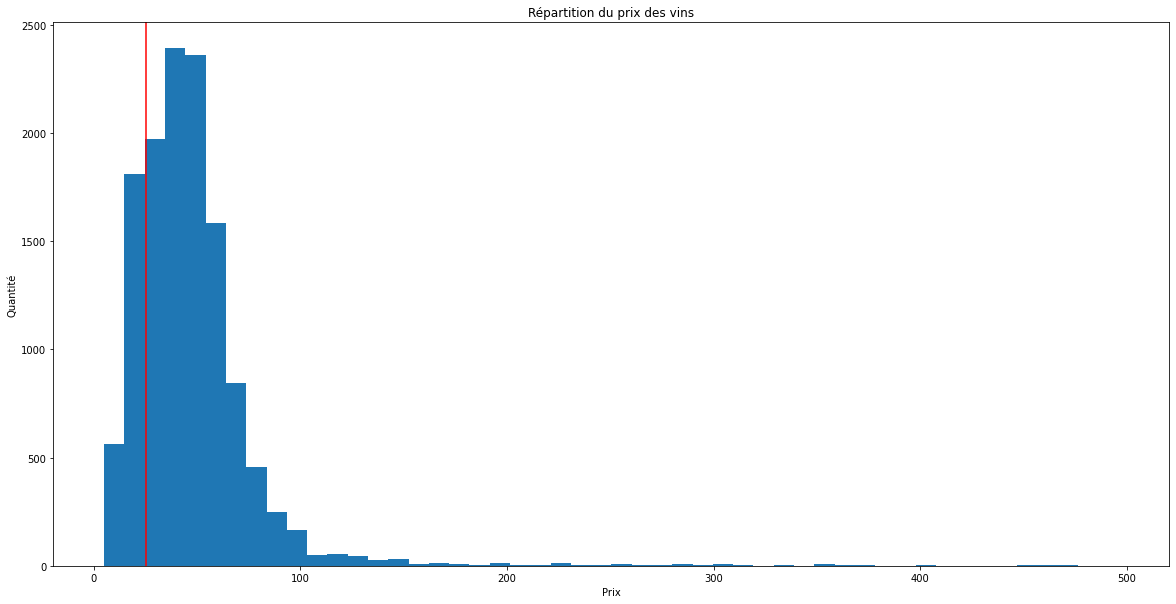

In [145]:
plt.figure(figsize=(20,10))
plt.hist(df_pinot_noir[df_pinot_noir['price'] < 500]['price'], bins = 50)
plt.axvline(x= 25, color = 'r')
plt.title('Répartition du prix des vins')
plt.xlabel('Prix')
plt.ylabel('Quantité')
plt.show()

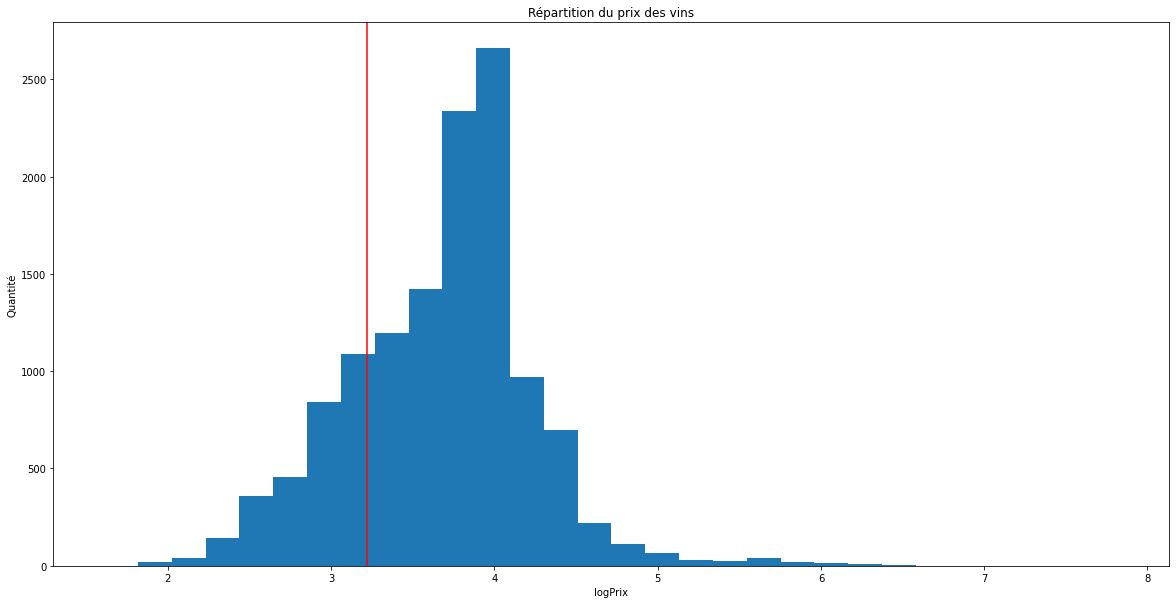

In [146]:
plt.figure(figsize=(20,10))
plt.hist(np.log(df_pinot_noir['price']), bins = 30)
plt.axvline(x= np.log(25), color = 'r')
plt.title('Répartition du prix des vins')
plt.xlabel('logPrix')
plt.ylabel('Quantité')
plt.show()

In [204]:
np.exp(np.log(df_pinot_noir['price']))

4          65.0
21         20.0
25         69.0
35         50.0
41         22.0
          ...  
129906     48.0
129917    107.0
129922     66.0
129946     48.0
129953     75.0
Name: price, Length: 12777, dtype: float64

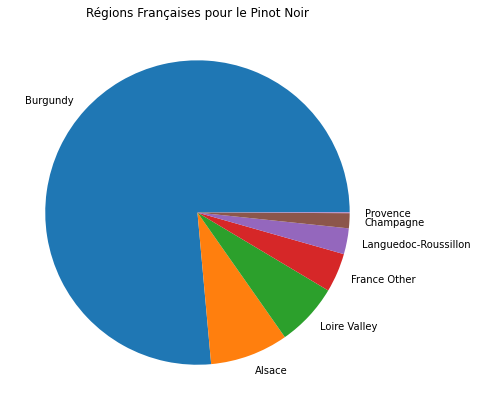

In [147]:
plt.figure(figsize=(15,7))
plt.pie(df_pinot_noir[df_pinot_noir['country'] == 'France']['province'].value_counts(), labels=df_pinot_noir[df_pinot_noir['country'] == 'France']['province'].unique())
plt.title('Régions Françaises pour le Pinot Noir')
plt.show()

## NLP
Do a word cloud of the most frequents words that are found in the wine descriptions.

In [148]:
descriptions = pd.DataFrame(df_pinot_noir['description'])
descriptions.head()

,description
4,"Much like the regular bottling from 2012, this..."
21,"A sleek mix of tart berry, stem and herb, alon..."
25,Oak and earth intermingle around robust aromas...
35,As with many of the Erath 2010 vineyard design...
41,"A stiff, tannic wine, this slowly opens and br..."


In [149]:
#tokenization
tokenizer = nltk.RegexpTokenizer(r'\w+')
descriptions['description']=descriptions['description'].apply(lambda x : tokenizer.tokenize(x))
descriptions.head()

,description
4,"[Much, like, the, regular, bottling, from, 201..."
21,"[A, sleek, mix, of, tart, berry, stem, and, he..."
25,"[Oak, and, earth, intermingle, around, robust,..."
35,"[As, with, many, of, the, Erath, 2010, vineyar..."
41,"[A, stiff, tannic, wine, this, slowly, opens, ..."


In [150]:
#majuscules
descriptions['description']=descriptions['description'].apply(lambda x : [word.lower() for word in x])
descriptions.head()

,description
4,"[much, like, the, regular, bottling, from, 201..."
21,"[a, sleek, mix, of, tart, berry, stem, and, he..."
25,"[oak, and, earth, intermingle, around, robust,..."
35,"[as, with, many, of, the, erath, 2010, vineyar..."
41,"[a, stiff, tannic, wine, this, slowly, opens, ..."


In [151]:
#stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
descriptions['description'] = descriptions['description'].apply(lambda x : [w for w in x if not w in stop_words])
descriptions.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description
4,"[much, like, regular, bottling, 2012, comes, a..."
21,"[sleek, mix, tart, berry, stem, herb, along, h..."
25,"[oak, earth, intermingle, around, robust, arom..."
35,"[many, erath, 2010, vineyard, designates, stro..."
41,"[stiff, tannic, wine, slowly, opens, brings, b..."


In [152]:
descriptions['description'] = descriptions['description'].apply(lambda x : ' '.join(x))
descriptions.head()

,description
4,much like regular bottling 2012 comes across r...
21,sleek mix tart berry stem herb along hint oak ...
25,oak earth intermingle around robust aromas wet...
35,many erath 2010 vineyard designates strongly h...
41,stiff tannic wine slowly opens brings brambly ...


In [153]:
liste_mots = list(descriptions['description'])
corpus = ' '.join(liste_mots)
print(corpus)

Output hidden; open in https://colab.research.google.com to view.

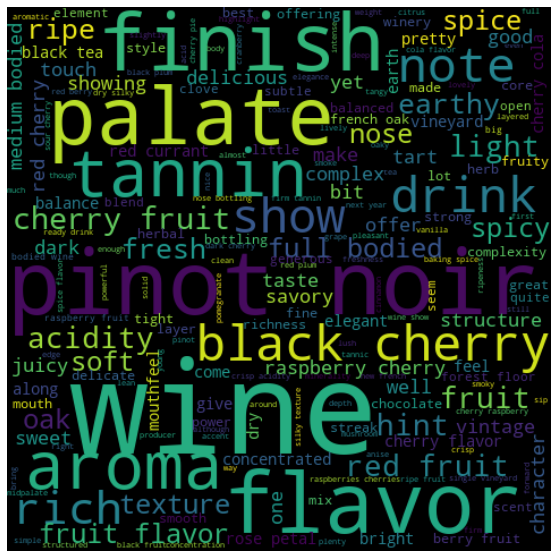

In [154]:
wordcloud = WordCloud(width=480, height=480, margin=0).generate(corpus)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Machine learning

Using the description of the wine, train a classifier that will predict if the wine is cheap or expensive. Train and evaluate your model, you should get at least 75% of accuracy. Then predict the class of your client's wines.




### Preprocessing

In [155]:
df_client['is_client'] = 1
df_130k['is_client'] = 0

df_total = pd.concat([df_130k, df_client], axis = 0)
df_total.reset_index(inplace = True, drop = True)
df_total.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality,is_client
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,cheap,0
1,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,cheap,0
2,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,cheap,0
3,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,expensive,0
4,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,cheap,0


In [157]:
df_total[df_total['is_client'] == 1].index

Int64Index([120964, 120965, 120966, 120967, 120968, 120969, 120970, 120971,
            120972, 120973, 120974, 120975, 120976, 120977],
           dtype='int64')

In [94]:
# tokenisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
df_total['description']=df_total['description'].apply(lambda x : tokenizer.tokenize(x))
#majuscules
df_total['description']=df_total['description'].apply(lambda x : [word.lower() for word in x])
#stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
df_total['description'] = df_total['description'].apply(lambda x : [w for w in x if not w in stop_words])
#join
df_total['description']=df_total['description'].apply(lambda x : ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
tfidf = TfidfVectorizer(max_features= 1000)
X = tfidf.fit_transform(df_total['description'])

In [97]:
pd.DataFrame(X.todense(),columns = tfidf.get_feature_names()).head()

,10,100,12,14,15,20,2009,2010,2011,2012,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2025,2030,25,30,40,50,60,70,80,accent,accented,accents,accessible,acid,acidic,acidity,acids,across,add,adding,...,want,warm,warmth,waves,way,weight,well,wet,whiff,whiffs,white,whole,wild,wine,winemaker,winery,wines,within,without,wonderful,wonderfully,wood,woody,work,world,would,wound,wrapped,year,years,yeast,yeasty,yellow,yet,young,youthful,zest,zesty,zin,zinfandel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.26767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123960,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.090310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126607,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.229173,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318126,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.284556,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.087045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129670,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.272414,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
wines_idx = df_total[df_total['is_client'] == 0].index

### Modélisation

In [86]:
#train test split
y = df_total['quality'][wines_idx]
X_train, X_test, y_train, y_test = train_test_split(X[wines_idx], y, test_size=0.25, random_state=42)

In [87]:
# modèle
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

In [88]:
#résultat
accuracy_score(y_test, y_pred)

0.7586389338976885

### Prediction

In [120]:
client_idx = df_total[df_total['is_client'] == 1].index

In [121]:
client_quality_pred = logreg.predict(X[client_idx])
client_quality_pred

array(['expensive', 'expensive', 'expensive', 'expensive', 'expensive',
       'expensive', 'expensive', 'expensive', 'expensive', 'expensive',
       'expensive', 'cheap', 'expensive', 'expensive'], dtype=object)

# Machine Learning (optional) 

Use all your Machine Learning skills to predict the price of your client's wines the more precise possible. You may use the columns of your choice and every skill you learned (CrossValidation and GridSearch for example).

In [161]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120978 entries, 0 to 120977
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             120978 non-null  int64  
 1   country                120919 non-null  object 
 2   description            120978 non-null  object 
 3   designation            86198 non-null   object 
 4   points                 120978 non-null  int64  
 5   price                  120964 non-null  float64
 6   province               120919 non-null  object 
 7   region_1               101403 non-null  object 
 8   region_2               50292 non-null   object 
 9   taster_name            96482 non-null   object 
 10  taster_twitter_handle  91562 non-null   object 
 11  title                  120978 non-null  object 
 12  variety                120977 non-null  object 
 13  winery                 120978 non-null  object 
 14  quality                120964 non-nu

In [201]:
df_total.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality,is_client,new_countries
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,cheap,0,Portugal
1,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,cheap,0,US


In [163]:
cols = ['country', 'points', 'variety']

In [177]:
country_cnts = pd.DataFrame(df_total.groupby(['country']).count()['description']).reset_index().rename(columns={"description": "count"})

In [182]:
country_cnts = country_cnts.sort_values(by = 'count', ascending = False)

In [200]:
country_cnts['proportion'] = country_cnts['count'] / len(df_total)
country_cnts.head(10)

,country,count,proportion,cumul_prop
39,US,54265,0.448553,0.448553
14,France,17779,0.146961,0.595513
21,Italy,16914,0.139811,0.735324
36,Spain,6573,0.054332,0.789656
30,Portugal,4875,0.040297,0.829953
8,Chile,4416,0.036503,0.866455
0,Argentina,3756,0.031047,0.897502
3,Austria,2799,0.023136,0.920638
2,Australia,2294,0.018962,0.939601
16,Germany,2120,0.017524,0.957124


In [184]:
country_cnts['cumul_prop'] = country_cnts['proportion'].cumsum()

In [190]:
countries_to_keep = country_cnts[country_cnts['cumul_prop'] <= 0.95]['country'].tolist()

In [191]:
countries_to_keep

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia']

In [194]:
df_total['new_countries'] = df_total['country'].apply(lambda x : x if x in countries_to_keep else 'other')

In [195]:
df_total['new_countries']

0         Portugal
1               US
2               US
3               US
4            Spain
            ...   
120973      France
120974      France
120975      France
120976      France
120977      France
Name: new_countries, Length: 120978, dtype: object

In [197]:
df_total.groupby(['new_countries']).count()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality,is_client
new_countries,,,,,,,,,,,,,,,,
Argentina,3756,3756,3756,2863,3756,3756,3756,3703,0,3753,3753,3756,3756,3756,3756,3756
Australia,2294,2294,2294,1618,2294,2294,2294,2292,0,2007,2007,2294,2294,2294,2294,2294
Austria,2799,2799,2799,2370,2799,2799,2799,0,0,2791,2791,2799,2799,2799,2799,2799
Chile,4416,4416,4416,3825,4416,4416,4416,0,0,4305,4305,4416,4415,4416,4416,4416
France,17779,17779,17779,11842,17779,17765,17779,17711,0,17528,17528,17779,17779,17779,17765,17779
Italy,16914,16914,16914,11993,16914,16914,16914,16889,0,10121,10121,16914,16914,16914,16914,16914
Portugal,4875,4875,4875,4381,4875,4875,4875,0,0,4870,4870,4875,4875,4875,4875,4875
Spain,6573,6573,6573,5257,6573,6573,6573,6565,0,6509,6509,6573,6573,6573,6573,6573
US,54265,54265,54265,36751,54265,54265,54265,53989,50292,37511,34535,54265,54265,54265,54265,54265
